# Experiment: SSVEP Classification with Canonical Correlation Analysis (CCA)

## Overview
In this experiment, we employed the Canonical Correlation Analysis (CCA) algorithm to classify Steady-State Visually Evoked Potential (SSVEP) signals at specific frequencies: 12.0 Hz, 8.57 Hz, 6.67 Hz, and 5.45 Hz. The primary objective is to classify SSVEP signals in response to stimulated frequencies using a Machine Learning model. The dataset used in this experiment consists of Fifty-four healthy subjects (ages 24-35; 25 females).

## Signal Preprocessing
The preprocessing of the EEG signals follows a four-step pipeline:

1. **Sample Rate**: The EEG data were acquired at a sample rate of 1000 Hz.

2. **Band-Pass Filtering**: Offline EEG data from the training phase underwent band-pass filtering between 4 and 44 Hz using a 5th order Butterworth digital filter. 

3. **Steady-State Visually Evoked Potential (SSVEP)**: For SSVEP performance validation, 10 electrodes in the occipital region were selected (P-3/z/4, PO-9/10, and O-1/z/2). Continuous EEG data were segmented from 0 to 4,000 ms with respect to stimulus onset, resulting in EEG epochs of dimensions 400 (data points) × 10 (electrodes) × 100 (trials). The decoding accuracy of the four target frequency indexes was computed using a multi-channel CCA approach.


## Table of Contents

- [0. Packages](#0)
    - [Custom packages](#0-1)
    - [Pythom packages](#0-2)
- [1. Experiment Params](#1)
- [2. Dataloader's configuration](#2)
    - [2.1 Data preview](#2-1)
- [3. Machine Learning Model](#3)
    - [Canonical Correlation Analysis (CCA)](#3-1)
- [4. Perfomance Results](#4)
    - [4.1. Considering only SSVEP task](#4-1)
    - [4.2. Considering SSVEP and MI tasks](#4-2)
        - [4.2.1. Delta algorithm](#4-2-1)
- [5. Save experiment Parameters](#5)


<a name="0"></a>
### Packages

<a name="0-1"></a>
#### Custom packages

In [1]:
import os, sys
processing_source_path = os.path.abspath('./../../../Processing/')
if(processing_source_path not in sys.path):
    sys.path.append(processing_source_path)
import ProcessingPipeline as pp

dataloader_source_path = os.path.abspath('./../../../Dataloader/')
if(dataloader_source_path not in sys.path):
    sys.path.append(dataloader_source_path)
from EEGDataGenRaw import EEGDataGen

utils_source_path = os.path.abspath('./../../../Utils/')
if(utils_source_path not in sys.path):
    sys.path.append(utils_source_path)

import utils
import available_metrics as metrics

<a name="0-2"></a>
#### Pythom packages

In [2]:
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation
import pandas as pd
import numpy as np

# File and Data Storage
from os.path import join
import datetime
import json
import time
import pickle

# Machine Learning and Metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

# Miscellaneous and Warnings
import warnings
warnings.simplefilter("ignore", UserWarning)


In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-11-28 15:36:56.512290: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 15:36:57.022422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 70464 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


<a name="1"></a>
### Experiment Params

In [4]:
data_params = {
    'dataset_path': '/root/EEGTests/',
    'dataset_name': 'BMIdataset',
    'h5_file_train': '/root/data/data/EEG/RAW/lee2019_ssvep_mi_raw_train_no_filters.h5py',
    'channels': ['O1', 'Oz', 'O2', 'PO10', 'PO9', 'POz', 'PO3', 'PO4'],
    'freqs': [0, 12.0, 8.57, 6.67, 5.45],
    'sampling_rate': 1000,
    'num_harmonics': 4,
    'sfreq': 1000,
    'subject': '5',
}

model_params = {
    'IA_Technique':'Machine Learning',
    'model_name': 'CCA',
    'num_classes': 5,
    'batch_size': 1
}
preprocessing_params = {
    'window_size': 2048,
    'window_step': 1023,
    'features_type': 'raw',
    "norm_axis": 1, #'normminmax_by_sample',
    'num_channels': len(data_params['channels']),
    "n_voting": 3,
}

# Combine all categories into a single dictionary
params = {**data_params, **model_params, **preprocessing_params}
#print("Params:", json.dumps(params, indent=2))

<a name="2"></a>
### Dataloader's configuration

In [5]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split

def train_val_test_split(h5_file_name, random_state=42, label_name='label', split_twice=True,subject=None):
    
    with h5py.File(h5_file_name, 'r') as hf:
        print(hf.keys())
        y = hf[label_name][...]
        y_task = hf['ep_flag'][...]
        y = np.hstack((y.reshape((-1, 1)), y_task.reshape((-1, 1))))
        subjects=hf['subject'][...]
        
    print(y.shape)

    # if y.ndim == 2 and y.shape[1] > 1:
        # y = np.argmax(y,axis=1)
    if subject== None:
        x = np.arange(y.shape[0])
    else:
        x=np.where(subjects==int(subject))[0]
        y=y[x,:]
        print(y.shape)
        
    x_full_train, x_val, y_full_train, y_val = train_test_split(x, y, test_size=0.1, random_state=random_state, stratify=y)
    
    if(split_twice):
        x_train, x_test, y_train, y_test = train_test_split(x_full_train, y_full_train, test_size=0.1, random_state=random_state, stratify=y_full_train)
    
    if(split_twice):
        return x_train, x_val, x_test
    else:
        return x_full_train, x_val
    
x_train, x_val, = train_val_test_split(params['h5_file_train'], random_state=42, label_name='label',split_twice=False, subject=params['subject'])

<KeysViewHDF5 ['eeg', 'ep_flag', 'label', 'session', 'subject']>
(8300, 2)
(300, 2)


In [6]:
subject =params['subject']
with h5py.File(params['h5_file_train'], 'r') as hf:
    print(hf.keys())
    y = hf['label'][...]
    y_task = hf['ep_flag'][...]
    y = np.hstack((y.reshape((-1, 1)), y_task.reshape((-1, 1))))
    subjects=hf['subject'][...]
    x_train=np.where(subjects==int(subject))[0]

<KeysViewHDF5 ['eeg', 'ep_flag', 'label', 'session', 'subject']>


In [7]:
data_processing = pp.ProcessingPipeline([
    pp.NormMinMax(axis=params['norm_axis']),  
]) 
filter_processing = pp.ProcessingPipeline([
    # band pass
    pp.HighPassFilter(4, 1000, 5),
    pp.LowPassFilter(44, 1000, 5),
    #pp.BandStopFilter(4, 44, 1000, 1),
    # anti aliasing
    pp.LowPassFilter(100, 1000, 5),
]) 
downsample_processing = pp.ProcessingPipeline([
    # downsample
    pp.Downsample(1000,250),
]) 

In [8]:
train_loader = EEGDataGen(params['h5_file_train'], x_train, batch_size=params['batch_size'], 
                      window_size=params['window_size'], window_step=params['window_step'], num_channels=params['num_channels'],
                      processing=data_processing, FilterProcessing=None, fft =False, sfreq=params['sampling_rate'],shuffle=False)

<a name="2-1"></a>
#### Data preview

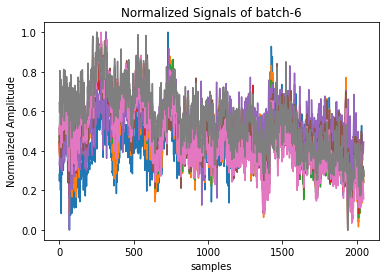

In [9]:
batch=6
# time Series
plt.plot(train_loader[batch][0][0])
plt.title(f'Normalized Signals of batch-{batch}')
plt.xlabel('samples')
plt.ylabel('Normalized Amplitude')
plt.show()

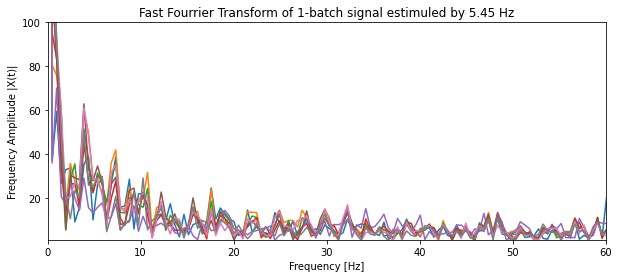

In [10]:
# fast fourrier transform
plt.figure(figsize=(10,4))
for ch in range(8): 
    utils.get_fft(train_loader[batch][0][0][:,ch],plot_data=True, get_data=True, sample_rate=params['sampling_rate'])
    plt.ylim(1,100)
    plt.xlim(0,60)
plt.title(f'Fast Fourrier Transform of 1-batch signal estimuled by {params["freqs"][np.argmax(train_loader[batch][1][0])]} Hz');

<a name="3"></a>
### Machine Learning Model

<a name="3-1"></a>
#### Canonical Correlation Analysis (CCA)

In [11]:
import warnings
warnings.filterwarnings('ignore')

#Load the model 
model_source_path = os.path.abspath('./../../../../embedded/EEG/CCA_model/')
if(model_source_path not in sys.path):
    sys.path.append(model_source_path)
    
from CCA_classify  import CCA_SSVEP

##### Get the model

In [12]:
CCA=CCA_SSVEP(sfreq=params['sfreq'],data_length=params['window_size'],ref_freqs = params['freqs'],N_harmonics=params['num_harmonics'])
#CCA=CCA_SSVEP(sfreq=params['sfreq'],data_length=256,ref_freqs = params['freqs'],N_harmonics=params['num_harmonics'])

In [13]:
## Run model in loop for each item in train_loader
prob_pred=[]
y_pred=[]
y_real=[]
y_task=[]
for idx in tqdm(range(len(train_loader))): 
    y_data,[yf,yt]=train_loader[idx]
    #y_data=downsample_processing(y_data)
    for batch in range(params['batch_size']):
        prob_pred+=[CCA.get_proba( y_data[batch] )]
        y_pred+=[CCA.predict( y_data[batch] )]
        y_real+=[yf[batch]]
        y_task+=[yt[batch]]
        
prob_pred = np.array(prob_pred)
y_pred = np.array(y_pred)
y_real = np.array(y_real)
y_task = np.array(y_task)

100%|██████████| 600/600 [00:15<00:00, 38.74it/s]


<a name="4"></a>
### Perfomance Result

<a name="4.1"></a>
###  Considering only SSVEP task

In [14]:
print('CCA Acc considering only SSVEP data:')
accuracy_score(np.argmax(y_real,axis=1)[np.argmax(y_task,axis=1)==1], y_pred[np.argmax(y_task,axis=1)==1])

CCA Acc considering only SSVEP data:


0.76

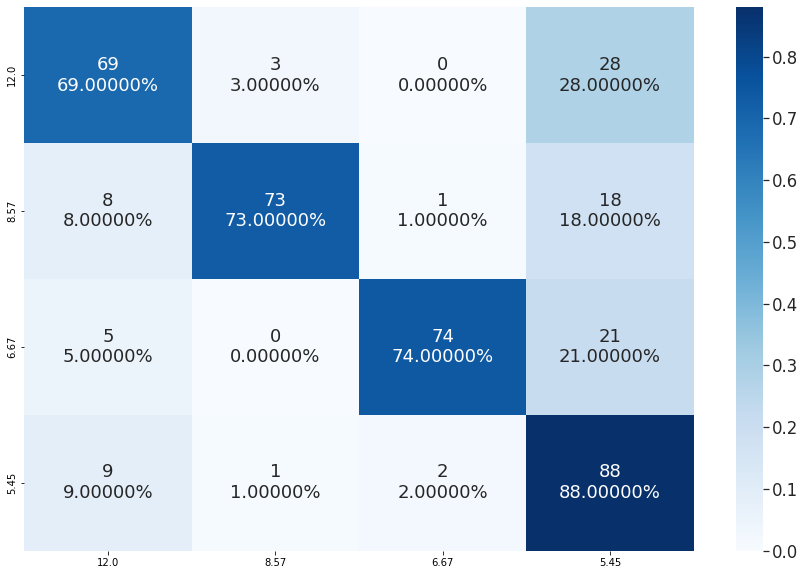

In [15]:
utils.plot_confusion_matrix(np.argmax(y_real,axis=1)[np.argmax(y_task,axis=1)==1], y_pred[np.argmax(y_task,axis=1)==1],params['freqs'][1:]);

<a name="4.2"></a>
### Considering SSVEP and MI tasks

In [16]:
print('CCA Acc considering SSVEP and MI data:')
accuracy_score(np.argmax(y_real,axis=1), y_pred)

CCA Acc considering SSVEP and MI data:


0.5066666666666667

array([[0.  , 0.05, 0.22, 0.19, 0.54],
       [0.  , 0.69, 0.03, 0.  , 0.28],
       [0.  , 0.08, 0.73, 0.01, 0.18],
       [0.  , 0.05, 0.  , 0.74, 0.21],
       [0.  , 0.09, 0.01, 0.02, 0.88]])

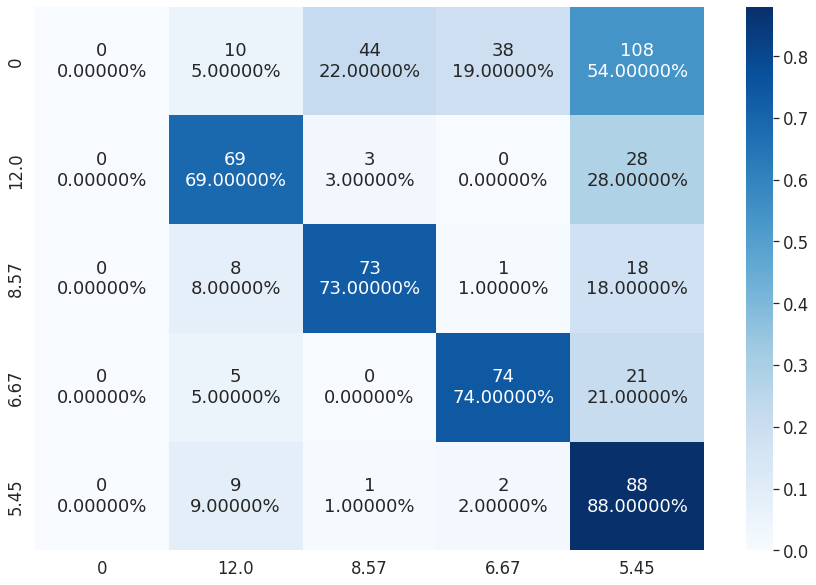

In [17]:
utils.plot_confusion_matrix(np.argmax(y_real,axis=1), y_pred,params['freqs'])

<a name="4-2-1"></a>
### Delta algorithm

In [18]:
# Grid searching to find the max acc for the thresholds
max_acc = 0
best_th1 = 0
best_th2 = 0

# Iterate over th1 and th2 values
for th1 in tqdm(np.arange(0, 1, 0.01)):
    for th2 in np.arange(0, 1, 0.01):
        
        # Get predictions using the delta technique
        delta_pred, _ = CCA.get_delta_pred(y_pred, prob_pred,th1, th2)
        
        # Calculate accuracy
        acc = accuracy_score(np.argmax(y_task, axis=1), delta_pred)
        
        # Update max_acc and best thresholds if a higher accuracy is found
        if acc > max_acc:
            max_acc = acc
            best_th1 = th1
            best_th2 = th2   
params['Delta-thresholds']=[best_th1,best_th2]

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


In [19]:
# use it to predict the CCA multi task using delta pred
y_pred_task, y_pred_freq=CCA.delta_predict(y_data[batch],params['Delta-thresholds'][0], params['Delta-thresholds'][0])

In [33]:
y_pred_freq=[]
y_pred_task=[]
for idx in tqdm(range(len(train_loader))): 
    y_data,[yf,yt]=train_loader[idx]
    #y_data=downsample_processing(y_data)
    for batch in range(params['batch_size']):
        y_t, y_f=CCA.delta_predict(y_data[batch],params['Delta-thresholds'][0], params['Delta-thresholds'][1])
        y_pred_task+=[y_t]
        y_pred_freq+=[y_f]
        
y_pred_task = np.array(y_pred_task)
y_pred_freq = np.array(y_pred_freq)

100%|██████████| 600/600 [00:08<00:00, 72.29it/s]


In [32]:
#delta_pred, y_pred_delta=CCA.get_delta_pred(y_pred, prob_pred,best_th1, best_th2)
#accuracy_score(np.argmax(y_task,axis=1), delta_pred)

acc=accuracy_score(np.argmax(y_task,axis=1), y_pred_task)
print('Delta detection threshold SSVEP data: Accuracy =', np.round(acc,3))


Delta detection threshold SSVEP data: Accuracy = 0.667


**Task Classification**

              precision    recall  f1-score   support

   Non SSVEP       0.33      1.00      0.50       200
       SSVEP       0.00      0.00      0.00       400

    accuracy                           0.33       600
   macro avg       0.17      0.50      0.25       600
weighted avg       0.11      0.33      0.17       600

Precision Score:  0.16666666666666666
Recall Score:  0.5
F1-Score:  0.25
Accuracy:  0.3333333333333333


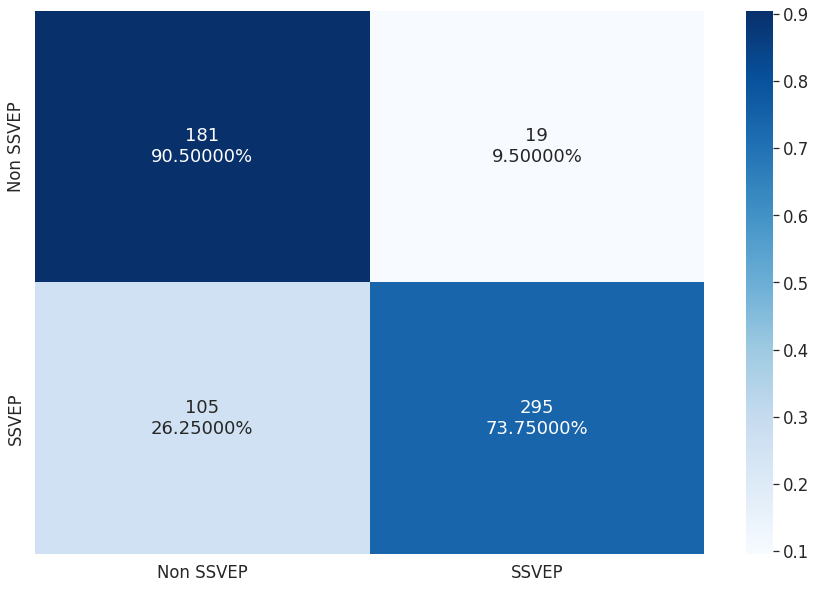

In [22]:
task_cfm=utils.plot_confusion_matrix(np.argmax(y_task,axis=1).reshape(-1,1), y_pred_task,['Non SSVEP','SSVEP'])
pr, re, f1, acc=metrics.model_metrics(['Non SSVEP','SSVEP'] ,np.argmax(y_task,axis=1).reshape(-1,1),delta_pred, Get_metrics=True) 
metrics_list_task=[pr, re, f1, acc]

**Frequency Classification**

              precision    recall  f1-score   support

           0       0.63      0.91      0.74       200
        12.0       0.78      0.52      0.62       100
        8.57       0.98      0.63      0.77       100
        6.67       1.00      0.63      0.77       100
        5.45       0.53      0.64      0.58       100

    accuracy                           0.70       600
   macro avg       0.79      0.67      0.70       600
weighted avg       0.76      0.70      0.71       600

Precision Score:  0.7853389738371082
Recall Score:  0.665
F1-Score:  0.6981454915620979
Accuracy:  0.705


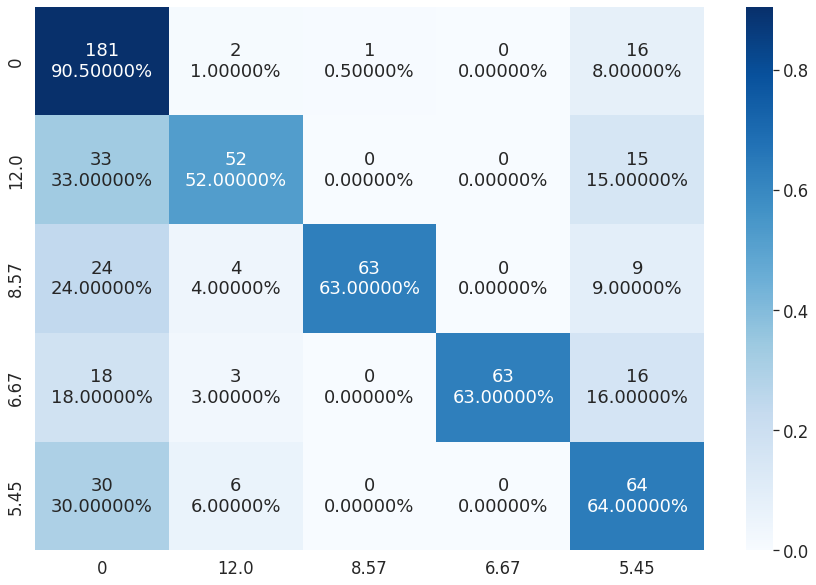

In [23]:
freq_cfm=utils.plot_confusion_matrix(np.argmax(y_real,axis=1).reshape(-1,1), y_pred_freq.reshape(-1,1),params['freqs'])

pr, re, f1, acc=metrics.model_metrics(params['freqs'] ,np.argmax(y_real,axis=1).reshape(-1,1), y_pred_freq.reshape(-1,1), Get_metrics=True) 
metrics_list_freq=[pr, re, f1, acc]

#### Accuracy and std for each classes

**Task Classification**

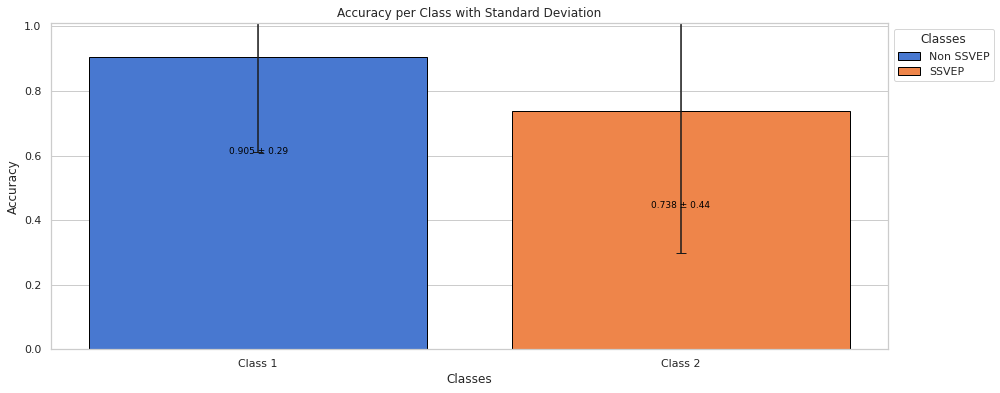

Precision Score: 0.8305±0.0554
Recall Score: 0.8212±0.0837
F1-Score: 0.82±0.0151
Accuracy: 0.8212±0.0837


In [24]:
metrics.plot_metric_per_class(task_cfm, ['Non SSVEP','SSVEP'], metric_name='Accuracy', method='per_class')
metrics_per_class,precision_list,recall_list,f1_score_list,accuracy_list=metrics.model_average_std_metrics(cf_matrix=task_cfm, Get_metrics=True, Verbose=True) 

**Frequency Classification**

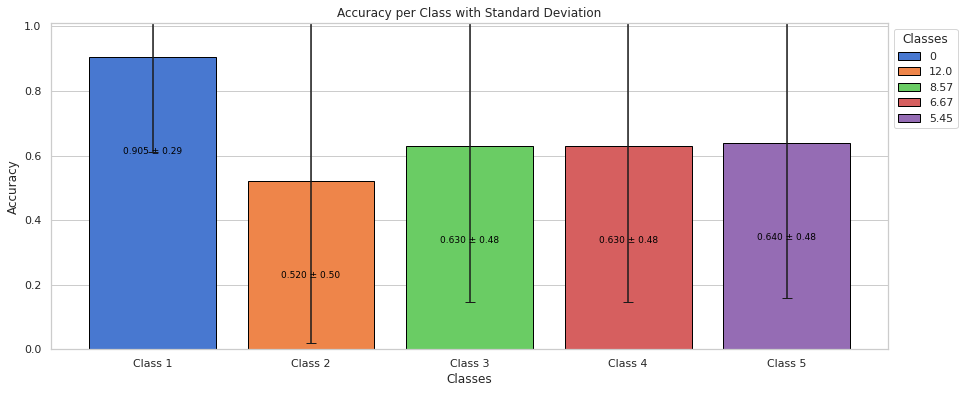

Precision Score: 0.7629±0.2173
Recall Score: 0.665±0.1278
F1-Score: 0.6773±0.0775
Accuracy: 0.665±0.1278


In [25]:
metrics.plot_metric_per_class(freq_cfm, params['freqs'], metric_name='Accuracy', method='per_class')
metrics_per_class,precision_list,recall_list,f1_score_list,accuracy_list=metrics.model_average_std_metrics(cf_matrix=freq_cfm, Get_metrics=True, Verbose=True) 

<a name="5"></a>
###  Save in mflow

In [26]:
from mlflow.tracking import MlflowClient
import mlflow
import sys
import shutil
import os
experiment_name = 'EEG_experiment'

def save_in_mlflow(params, cfm=None, fig_pca=None, roc_score_per_class=None):
    # Set the tracking URI to a local directory
    sys.path.append('/root/IA-Algorithms-main/mlruns')
    mlflow.set_tracking_uri("file:/root/IA-Algorithms-main/mlruns")

    mlflow.set_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    with mlflow.start_run(experiment_id=experiment.experiment_id):
        
        for category in params:
            mlflow.log_param(category, params[category])
                        
        if cfm is not None:
            # Log confusion matrix values
            mlflow.log_param("confusion_matrix_task", cfm[0].tolist())
            mlflow.log_param("confusion_matrix_freq", cfm[1].tolist())

            try:
                if os.path.exists(fig_pca):
                    mlflow.log_artifact(fig_pca, artifact_path='images')
                    os.remove(fig_pca)
                    mlflow.log_param('features_pca_name', fig_pca)
            except Exception as error:
                print("An exception occurred during the log of the figure-PCA:",error) 
        print("--------------------------------------------------------------------" )
        print("Params saved successful !!" ) 

In [27]:
save_in_mlflow(params, cfm=[task_cfm,freq_cfm], fig_pca=None, roc_score_per_class=None)

An exception occurred during the log of the figure-PCA: stat: path should be string, bytes, os.PathLike or integer, not NoneType
--------------------------------------------------------------------
Params saved successful !!
